# OpenAI Intent Classifier
*This Notebook explores the ATIS dataset and implements a zero- or few-shot intent classifier based on a fine-tuned GPT3 model, that can be used to provide inferencing service via an HTTP Service.*

[GitHub repo](https://github.com/alexdjulin/openai-intent-classifier)  
[Kaggle Notebook](https://www.kaggle.com/code/alexandredj/intent-classifier-based-on-fine-tuned-gpt3#OpenAI-Intent-Classifier)

# Modules installation
To run the notebook code below, you need the following python modules.  
Create a virtual environment if needed first, before running the install cell.

In [87]:
%%script false

!pip install pandas
!pip install numpy  # should come with pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install openai
!pip install python-dotenv
!pip install kaggle

Couldn't find program: 'false'


# Module imports

In [88]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from openai import OpenAI

# load environment variables from .env file
import dotenv
dotenv.load_dotenv()


True

## API-KEY
To run the OpenAI calls below, you need a valid [OpenAI API key](https://platform.openai.com/api-keys). Create an .env file at the root an add your key (see .env-example).

# Dataset Review
Let's look at the [ATIS Airline Travel Information System](https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem) dataset.

### Download Dataset

In [89]:
!kaggle datasets download -d hassanamin/atis-airlinetravelinformationsystem

atis_path = 'atis_dataset'
zip_file = 'atis-airlinetravelinformationsystem.zip'
# unzip dataset
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(atis_path)
    

Dataset URL: https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem
License(s): GPL-2.0
atis-airlinetravelinformationsystem.zip: Skipping, found more recently modified local copy (use --force to force download)


### Load Dataset

In [168]:
atis_train_csv = os.path.join(atis_path, 'atis_intents_train.csv')
atis_test_csv = os.path.join(atis_path, 'atis_intents_test.csv')

atis_train_df = pd.read_csv(atis_train_csv, names=['intent', 'message'])
atis_test_df = pd.read_csv(atis_test_csv, names=['intent', 'message'])

print('Train samples:', len(atis_train_df))
print('Test samples:', len(atis_test_df))
total_samples = len(atis_train_df) + len(atis_test_df)
print('Total samples:', total_samples)


Train samples: 4834
Test samples: 800
Total samples: 5634


### Display the first 10 rows of the dataset

In [173]:
def print_df_head(df, samples=10):
    for i in range(min(samples, len(df))):
        print(f"[{df['message'][i]}] --> [{df['intent'][i]}]")

print_df_head(atis_train_df)

[ i want to fly from boston at 838 am and arrive in denver at 1110 in the morning] --> [atis_flight]
[ what flights are available from pittsburgh to baltimore on thursday morning] --> [atis_flight]
[ what is the arrival time in san francisco for the 755 am flight leaving washington] --> [atis_flight_time]
[ cheapest airfare from tacoma to orlando] --> [atis_airfare]
[ round trip fares from pittsburgh to philadelphia under 1000 dollars] --> [atis_airfare]
[ i need a flight tomorrow from columbus to minneapolis] --> [atis_flight]
[ what kind of aircraft is used on a flight from cleveland to dallas] --> [atis_aircraft]
[ show me the flights from pittsburgh to los angeles on thursday] --> [atis_flight]
[ all flights from boston to washington] --> [atis_flight]
[ what kind of ground transportation is available in denver] --> [atis_ground_service]


### Fix dataset issues
There are two minor issues we need to fix:
- There seem to be useless spaces at the beginning of all messages, let's remove them.
- All intents are prefixed with 'atis_', let's get rid of it.

In [174]:
# Strip spaces around the message
atis_train_df['message'] = atis_train_df['message'].apply(lambda x: x.strip())
atis_test_df['message'] = atis_test_df['message'].apply(lambda x: x.strip())

# Remove atis_ prefix
atis_train_df['intent'] = atis_train_df['intent'].apply(lambda x: x.replace('atis_', ''))
atis_test_df['intent'] = atis_test_df['intent'].apply(lambda x: x.replace('atis_', ''))

for i, message in enumerate(range(10)):
    print(f"[{atis_train_df['message'][message]}] --> [{atis_train_df['intent'][message]}]")

[i want to fly from boston at 838 am and arrive in denver at 1110 in the morning] --> [flight]
[what flights are available from pittsburgh to baltimore on thursday morning] --> [flight]
[what is the arrival time in san francisco for the 755 am flight leaving washington] --> [flight_time]
[cheapest airfare from tacoma to orlando] --> [airfare]
[round trip fares from pittsburgh to philadelphia under 1000 dollars] --> [airfare]
[i need a flight tomorrow from columbus to minneapolis] --> [flight]
[what kind of aircraft is used on a flight from cleveland to dallas] --> [aircraft]
[show me the flights from pittsburgh to los angeles on thursday] --> [flight]
[all flights from boston to washington] --> [flight]
[what kind of ground transportation is available in denver] --> [ground_service]


### Create Train, Validation and Test sets
It would be nice to have a validation and a test set. The first one for training/fine-tuning, the second one to have unseed data to test our final model.
- The rename our test set into validation (conventional name)
- Let's take 500 samples from the train set and create a test set.

In [94]:
# create validation set
val_df = atis_test_df.copy()

# shuffel train set
atis_train_df = atis_train_df.sample(frac=1).reset_index(drop=True)

# cresate train and test set
samples = 550
train_df, test_df = atis_train_df[:-samples], atis_train_df[-samples:]

# reset indexes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f"Training set: {len(train_df)} samples, {len(train_df)/total_samples*100:.0f}%")
print(f"Validation set: {len(val_df)} samples, {len(val_df)/total_samples*100:.0f}%")
print(f"Test set: {len(test_df)} samples, {len(test_df)/total_samples*100:.0f}%")

Training set: 4284 samples, 76%
Validation set: 800 samples, 14%
Test set: 550 samples, 10%


### Get a random message and intent from a set
For quick testing, let's create a method that returns a random message from a set passed as argument.

In [95]:
def get_random_message_intent(df=None):

    if df is None:
        df = test_df
    
    index = randint(0, len(df))
    message = df['message'][index]
    intent = df['intent'][index]
    
    return message, intent

message, intent = get_random_message_intent()
print(f"{message} --> {intent}")

 i'd like to find a flight between dallas and philadelphia --> flight


### Review dataset intents

If you look at the distribution of messages per intent (see lists and confusion matrix below), you can see that the dataset is highly unbalanced, with most messages corresponding to the *flight* intent. This will restrain our training methods. Most usual Machine Learning or Deep Learning training methods won't provide us with good results, as they require large and even dataset samples.

In [96]:
train_intents = list_intents(train_df)
val_intents = list_intents(val_df)
test_intents = list_intents(test_df)
intents_list = list(train_intents.union(val_intents).union(test_intents))

print(f'{len(train_intents)} Train intents:', train_intents)
print(f'{len(val_intents)} Validation intents:', val_intents)
print(f'{len(test_intents)} Test intents:', test_intents)
print(f'TOTAL: {len(intents_list)} unique intents:', intents_list)

8 Train intents: {'flight', 'airfare', 'abbreviation', 'airline', 'flight_time', 'aircraft', 'quantity', 'ground_service'}
8 Validation intents: {'flight', 'airfare', 'abbreviation', 'airline', 'flight_time', 'aircraft', 'quantity', 'ground_service'}
8 Test intents: {'flight', 'airfare', 'abbreviation', 'airline', 'flight_time', 'aircraft', 'quantity', 'ground_service'}
TOTAL: 8 unique intents: ['flight', 'airfare', 'abbreviation', 'airline', 'flight_time', 'aircraft', 'quantity', 'ground_service']


In [97]:
# Number of messages per intent
train_intent_counts = train_df['intent'].value_counts()
val_intent_counts = val_df['intent'].value_counts()
test_intent_counts = test_df['intent'].value_counts()

print("\nNumber of messages per intent in the training set:")
print(train_intent_counts)
print()
print("Number of messages per intent in the validation set:")
print(val_intent_counts)
print()
print("Number of messages per intent in the test set:")
print(test_intent_counts)


Number of messages per intent in the training set:
intent
flight            3244
airfare            376
ground_service     232
airline            135
abbreviation       128
aircraft            73
quantity            48
flight_time         48
Name: count, dtype: int64

Number of messages per intent in the validation set:
intent
flight            632
airfare            48
airline            38
ground_service     36
abbreviation       33
aircraft            9
quantity            3
flight_time         1
Name: count, dtype: int64

Number of messages per intent in the test set:
intent
flight            422
airfare            47
ground_service     23
airline            22
abbreviation       19
aircraft            8
flight_time         6
quantity            3
Name: count, dtype: int64


### Message lengths / Tokens

Let's have a look at messages length.

Train set message length:
count    4284.000000
mean       65.179972
std        23.506792
min         7.000000
25%        50.000000
50%        63.000000
75%        78.000000
max       260.000000
Name: message, dtype: float64

Validatoin set message length:
count    800.000000
mean      58.938750
std       21.486789
min       12.000000
25%       46.000000
50%       56.500000
75%       71.000000
max      175.000000
Name: message, dtype: float64

Test set message length:
count    550.000000
mean      63.685455
std       22.432842
min       11.000000
25%       49.000000
50%       61.000000
75%       76.000000
max      170.000000
Name: message, dtype: float64


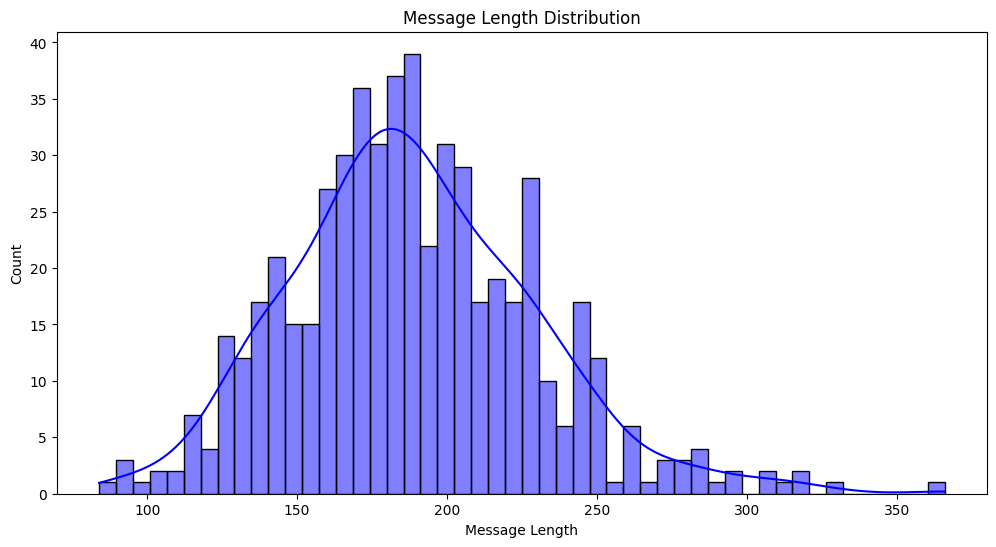

In [98]:
# check message length
train_df_len = train_df['message'].apply(len)
val_df_len = val_df['message'].apply(len)
test_df_len = test_df['message'].apply(len)

# print message length statistics
print("Train set message length:")
print(train_df_len.describe())
print()
print("Validatoin set message length:")
print(val_df_len.describe())
print()
print("Test set message length:")
print(test_df_len.describe())

# plot message length distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_df_len + val_df_len + test_df_len, bins=50, color='blue', kde=True)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()


The average message length of our 3 datasets seems to be around 185 characters.

### Train a Machine Learning model on the dataset
Let's train a simple Regression model on our dataset. This can be useful to visualise its structure, using the Confusion Matrix for instance.

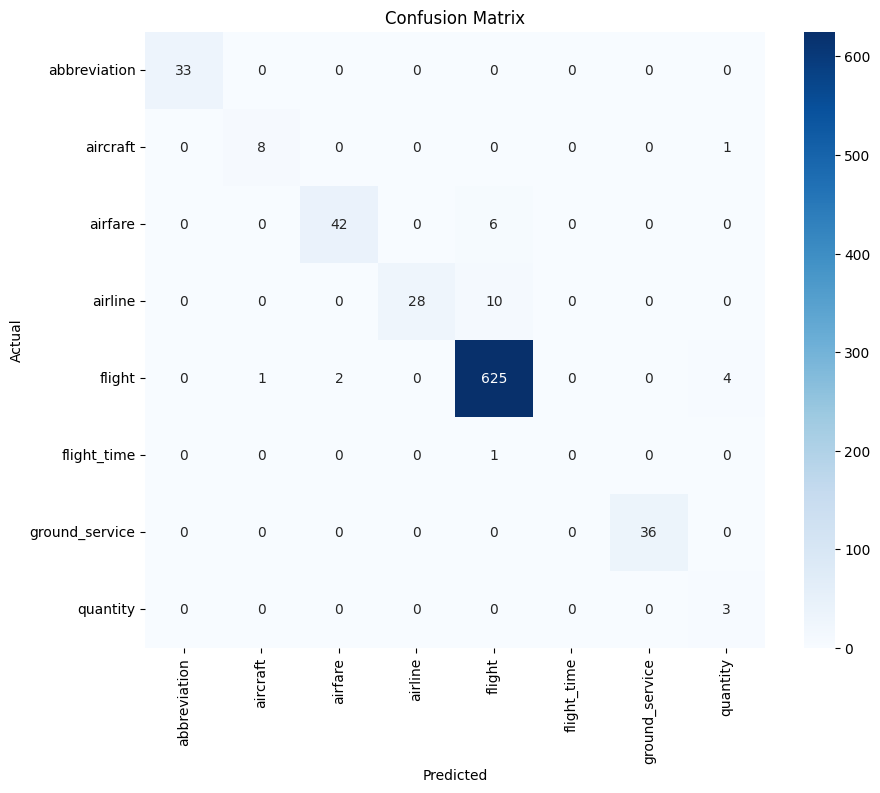

                precision    recall  f1-score   support

  abbreviation       1.00      1.00      1.00        33
      aircraft       0.89      0.89      0.89         9
       airfare       0.95      0.88      0.91        48
       airline       1.00      0.74      0.85        38
        flight       0.97      0.99      0.98       632
   flight_time       0.00      0.00      0.00         1
ground_service       1.00      1.00      1.00        36
      quantity       0.38      1.00      0.55         3

      accuracy                           0.97       800
     macro avg       0.77      0.81      0.77       800
  weighted avg       0.97      0.97      0.97       800



In [99]:
X_train, X_val, y_train, y_val = train_df['message'], val_df['message'], train_df['intent'], val_df['intent']

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train a ML classifier
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_val_tfidf)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred, labels=classifier.classes_)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report for more detailed metrics
print(classification_report(y_val, y_pred, zero_division=0))

As said above, the ATIS dataset is highly unbalanced, with a large amount of messages in some classes like *flight*, *airfare* or *ground_service* but way fewer in others, like *flight_time*, *quantity* or *aircraft*. The f1-score goes over 90% on these classes but is much lower or simply 0 on low-sample classes.

Therefore, a zero- or few-shot solution would indeed give us the best results. A Machine Learning approach like above or a Deep Learning solution (LSTM/GRU/Conv1D) would give us poor result.

# Create Model
Let's settle on a LLM and configure it to perform intent-classifing tasks.

After running some prediction tests, I decided to build the classifier on the lastest version of GPT3: `gpt-3.5-turbo-0125`, to give results better suited to our use case.

### Benefits

- GPT3 offers great classification performances out of the box. The model predicts the correct intent out of the list most of the time, without any prior knowledge of the dataset. It works with raw text data and can parse and understand multiple languages. No need to tokenize the input, create embeddings or run through a translation step first.
  
- The model is running in the cloud, no need to download and run it locally, thus drastically saving on disk space (GPT3 is about 350 GB).
  
- GPT3 can be fine-tuned on the ATIS dataset. The operation happens via the online interface on OpenAI's GPUs. No need for a strong CUDA/GPU hardware locally.
  
- GPT3 completion algorithm offers a JSON option, ensuring that we will always get an answer in this format. It worked during all my tests.
  
- The latency when sending a request to OpenAI and getting back the answer is very short, especially for a cloud-based model. I never had to wait more than 1 second, even on very long prompts.
  
- Using a GPT model makes it very easy to swap to another model. Since they all run in the cloud, we can upgrade our model just by changing the name id. This could even happen in real time during a conversation (customer is changing subject, we load a model better suited to the new context).

- Expanding or replacing the list of valid intents to chose from is very easy and can be done in the prompt directly, without the need of re-training the model.

- The context window of 16k tokens ensures that we can input large amount of text and long conversations. Of course, we could implement an additional summarizing step if prompts get too long.
 
- The costs of using and fine-tuning GPT3 are still much lower than for GPT4 models, for similar results considering our use-case.
  
- Finally, on a personal note, I find GPT models easy to use and I already had past experience working with them.

### Bottlenecks / Drawbacks

- The main drawback building our intent classifyier on a GPT model is obviously that we depends on OpenAI services. Any technical problem on their side would impact us. We are also impacted by any change in the API they would implement or models they would deprecate overtime.   

- Regarding the costs, we are not on a free and open-source solution. Scaling it up to target a large amount of customers could eventually becomes expensive, even if we consider the current Pricing, which is very low ($0.50 input / $1.50 output for 1M tokens).

- Regarding the fine-tuning possibilities, we are limited by OpenAI's API and restrictions. While we do have access to multiple hyperparameters, the fine-tuning operation is running on OpenAI's servers and out of our hands. It is difficult to assess exactly how it is happening and what PEFT methods are used, considering the size and complexity of the GPT models. The interest in fine-tuning our own model most probably depends on the dataset and use-case. Also let's keep in mind that fine-tuning a model is much more expensive than using it ($8.00 training, $3.00 input usage and $6.00 output usage for 1M tokens).


### Desired Input / Output
We want to build a HTTP infering service to send a message to our model and get the resulting intents. We should therefore use the JSON format for all data exchange, so our flask application can handle them properly.

**INPUT:**  

```json
POST /intent
Content-Type: application/json
{
    "text": "find me a flight that flies from memphis to tacoma"
}
```

**OUTPUT:**  

```json
{
    "intent": "flight"
}
```

## Using OpenAI GPT3
Let's have a look at GPT3 from OpenAI and how it performs on intent classification tasks.

We will use the latest version, `gpt-3.5-turbo-0125`, as it can be fine-tuned too.

[API documentation](https://platform.openai.com/docs/guides/text-generation)

In [180]:
gpt_model = 'gpt-3.5-turbo-0125'

### Create our prompt and completion method call 

We need an efficient and cost-effective prompt to ensure that our model understands the following specifications:  
- **Describe the task**: We are performing intent classification
  
- **List the valid intents**: The predicted intent should be picked from the list only
  
- **Describe the output**: The argument `response_format={"type": "json_object"}` along with the word *JSON* specified in the prompt ensures that our model will format all answers as such
  
- **Examples**: Give at least one user / assistant example to help the model
  
- **Add current task**: Finish with the current message we want our model to predict the intent on

- **Handle confusing or out-of-context messages**: If the message is confusing, the model should still try to understand what the customer is asking for. However, if the message makes no sense or is out of context, we should skip the prediction and return an empty list.

In [175]:
# create client to interact with openai API
client = OpenAI()

def get_intent_predictions(message, intents, model, verbose=False):

    prompt = [
        {
            "role": "system", 
            "content": f"""
            Role: You are a helpful intent classifier for virtual assistant interactions.
            Context: The following dialog involves a user interacting with a virtual assistant in the context of Airline Travel Information.
            Predefined Intents: You should pick the corresponding intent from the list: {intents}.
            If the message does not make sense, try to guess what the customer is asking for.
            If the message is empty or out of context, return an empty string.
            Output: You output the most probable prediction intent using JSON as follows.
            """
        },
        {
            "role": "user",
            "content": json.dumps({"text": "find me a flight that flies from memphis to tacoma"})
        },
        {
            "role": "assistant",
            "content": json.dumps({"intent": "flight"})
        },
        {
            "role": "user",
            "content": json.dumps({"text": message})
        }
    ]

    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=prompt,
        max_tokens=100,
        temperature=0,
        top_p=1,
        frequency_penalty=0.5,
        presence_penalty=0,
    )

    # print tokens / debug information
    if verbose:
        print('Intents:', response.choices[0].message.content)
        print('Tokens:', response.usage)
        print()

    return response.choices[0].message.content


### Test model completion

In [176]:
message, intent = get_random_message_intent()

response = get_intent_predictions(message, intents_list, model=gpt_model, verbose=True)

data = json.loads(response)
openai_intent = data['intent']

print(f"MESSAGE: {message} | INTENT: {intent}")
print(f"OUTPUT: {data}")

Intents: {"intent": "airfare"}
Tokens: CompletionUsage(completion_tokens=7, prompt_tokens=194, total_tokens=201)

MESSAGE:  list all round trip fares from pittsburgh to washington dc | INTENT: airfare
OUTPUT: {'intent': 'airfare'}


Our completion call requires around **200 tokens**, which should be no issue for gpt-3.5-turbo 16k-token context window, even on long conversations.

Regarding the costs, that's about **$0,0001** for the prompt and **$0,00001** for the completion tokens, which is very low, even if we scale up our solution and target a large amount of customers.

### Test model with additional intents
What if we want to expand our list of intents? Or even replace it completely?  
We can easily add or replace intents inside our prompt directly, as below. Our GPT model will consider them when generating the output list. This is one major benefit of using a LLM as intent classifier, whereas we should re-train the model on a large amount of matching samples, if we were to use a ML or DL approach.

In [103]:
# Let's add two new intents to the list and send a corresponding message
expanded_intents_list = intents_list + ['strike', 'refund']  # mandatory addition for French airlines :)
messages = ['I want to cancel my flight to NYC due to a strike.', 'Can I get a refund for my flight to Paris CDG, the plane was 3 hours late?']

for message in messages:
    response = get_intent_predictions(message, expanded_intents_list, model=gpt_model)
    data = json.loads(response)
    openai_intent = data['intent']
    print(f"MESSAGE: {message}")
    print(f"OUTPUT: {data}")

MESSAGE: I want to cancel my flight to NYC due to a strike.
OUTPUT: {'intent': 'strike'}
MESSAGE: Can I get a refund for my flight to Paris CDG, the plane was 3 hours late?
OUTPUT: {'intent': 'refund'}


### Assess the model results

Let's see how our model performs on 100 random messages from our test set and their corresponding true intent label.  

GPT model: gpt-3.5-turbo-0125


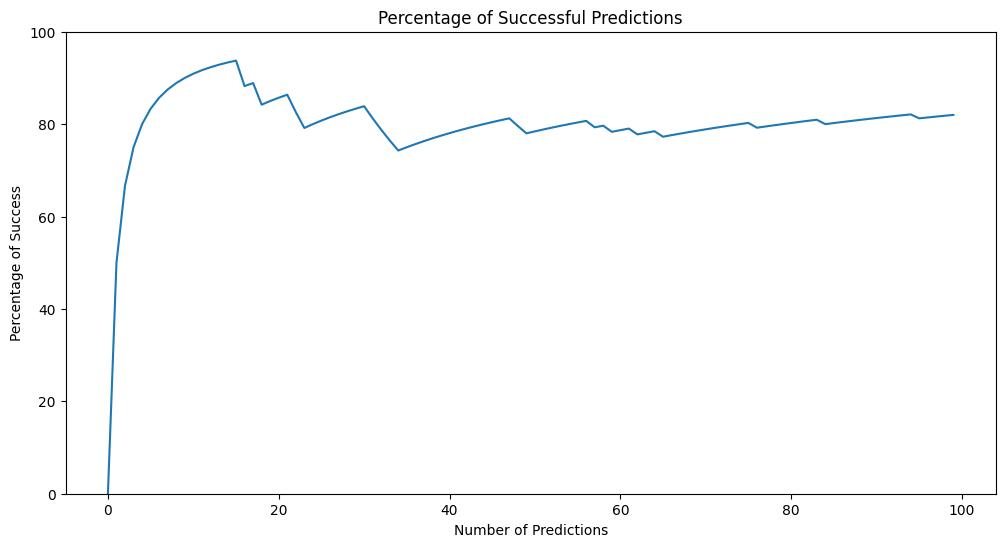

False Prediction Examples:
1.  what is the latest flight leaving las vegas for ontario | TRUE: flight | PREDICTED: flight_time
2.  which airline offers the cheapest rate going from dallas to baltimore on july fourth | TRUE: airline | PREDICTED: airfare
3.  list the earliest flights from st. paul to houston | TRUE: flight | PREDICTED: flight_time
4.  i need a flight to atlanta this afternoon | TRUE: flight | PREDICTED: flight_time
5.  the most expensive flight between boston and philadelphia | TRUE: flight | PREDICTED: airfare
6.  what do you have from philadelphia to dallas on saturday morning | TRUE: flight | PREDICTED: flight_time
7.  what is the earliest flight from boston to atlanta | TRUE: flight | PREDICTED: flight_time
8.  all flights before 10 am boston denver | TRUE: flight | PREDICTED: flight_time
9.  show me the cheapest flights from dallas to baltimore | TRUE: flight | PREDICTED: airfare
10.  does flight dl 1083 from philadelphia to denver fly on saturdays | TRUE: flight | 

In [181]:
def asses_model_results(model, samples=100):
        
    true_label_found = 0
    true_label_not_found = 0
    pred_label_plot = []
    index_list = []
    false_predictions = {}
    
    df = test_df.copy()

    for p in range(samples):
        
        # make sure we don't get the same message twice
        while True:
            index = randint(0, len(df))
            if index not in index_list:
                index_list.append(index)
                break

        message, true_intent = df['message'][index], df['intent'][index]

        response = get_intent_predictions(message, intents_list, model=model)
        data = json.loads(response)

        # get predicted intents
        pred_intent = data.get('intent', '')

        # log result
        if true_intent == pred_intent:
            true_label_found += 1
        else:
            true_label_not_found += 1
            false_predictions[message] = {'true_intent': true_intent, 'pred_intent': pred_intent}
        
        # store prediction success for plotting
        success_rate = true_label_found/(p+1)*100
        failure_rate = true_label_not_found/(p+1)*100

        pred_label_plot.append(success_rate)

        print(f"Predictions: {p+1} | "
            f"Successful Prediction: {true_label_found} ({success_rate:.0f}%) | "
            f"Failed Prediction: {true_label_not_found} ({failure_rate:.0f}%)", end='\r')
        
        # remove message from the dataset to avoid duplicate predictions
        df = df[df['message'] != message]

    # plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(pred_label_plot)
    plt.ylim(0, 100)
    plt.title('Percentage of Successful Predictions')
    plt.xlabel('Number of Predictions')
    plt.ylabel('Percentage of Success')
    plt.show()

    # let's look at some of the failed predictions
    if false_predictions:
        print('False Prediction Examples:')
        for i, (message, data) in enumerate(false_predictions.items()):
            print(f"{i+1}. {message} | TRUE: {data['true_intent']} | PREDICTED: {data['pred_intent']}")

print('GPT model:', gpt_model)
asses_model_results(model=gpt_model, samples=100)


Results:  

```
Predictions: 100
Successful Prediction: 82 (82%)
Failed Prediction: 18 (18%)
```
GPT3 is doing a pretty good job already, predicting the true label about 80% of the cases already. Moreover, if we look at the list of true Vs. predicted intents, the error are quite forgivable. Most of the time, GPT3 predicts *flight_time* instead of *flight*, when both answers are definitely valid.

## Fine-tuning GPT3 to better match our intents

Let's fine-tune GPT3 on the ATIS dataset and see if we can get better predictions.

Not all GPT models are available for fine-tuning. This is why we picked `gpt-3.5-turbo-0125`, which is the flagship model of the GPT3 family and also the recommended one for fine-tuning.  

To reduce training time and [costs](https://openai.com/api/pricing/), I limited this operation to 1000 training and 100 validation samples.

[API documentation](https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset)

### Prepare the training data

The OpenAI API requires data stored in jsonl format, as follows. My first task was to write down the ATIS dataset samples to jsonl files.

```jsonl
{"messages": [
    {"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, 
    {"role": "user", "content": "What's the capital of France?"}, 
    {"role": "assistant", "content": "Paris", "weight": 0}, 
    {"role": "user", "content": "Can you be more sarcastic?"}, 
    {"role": "assistant", "content": "Paris, as if everyone doesn't know that already.", "weight": 1}
]}
```

In [110]:
# create fine_tuning directory if needed
os.makedirs('fine_tuning', exist_ok=True)

# shuffle train and test dataframes
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

system_prompt = "You are an intent classifier for virtual assistant interactions, which predicts the most probable intent from an input message."

def create_jsonl_file(df, jsonl_file, samples=None):

    if samples is None:
        samples = len(df)

    # deletes the file if it already exists
    if os.path.exists(jsonl_file):
        os.remove(jsonl_file)

    # browse through the dataset and write the messages to the jsonl file
    for i in range(samples):
        message = df['message'][i]
        intent = df['intent'][i]
        message_json = json.dumps(
            {
                "messages": [
                    {
                        "role": "system", "content": system_prompt
                    }, 
                    {
                        "role": "user", "content": message
                    }, 
                    {
                        "role": "assistant", "content": json.dumps({"intent": intent})
                    }
                ]
            }
        )
        
        # writes the message to the jsonl file
        with open(jsonl_file, 'a') as file:
            file.write(message_json)
            file.write('\n')

train_jsonl_file = "fine_tuning/train.jsonl"
val_jsonl_file = "fine_tuning/val.jsonl"

create_jsonl_file(train_df, train_jsonl_file, samples=1000)
create_jsonl_file(test_df, val_jsonl_file, samples=100)

### Upload our training and testing files

Both jsonl files need to be sent to OpenAI for fine-tuning.

In [113]:
train_file = client.files.create(
    file=open(train_jsonl_file, "rb"), 
    purpose="fine-tune"
    )

val_file = client.files.create(
    file=open(val_jsonl_file, "rb"), 
    purpose="fine-tune"
    )

print(train_file)
print(val_file)


FileObject(id='file-2NWr5q7FRxyxonmlsBLPzxgJ', bytes=339833, created_at=1717668320, filename='train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)
FileObject(id='file-rlMj2sHwpo5ZMqTHSHAe9aQH', bytes=33826, created_at=1717668321, filename='val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


### Create fine-tuning job
I used the default hyperparameters, which should be fine for our use-case.

[API documenation](https://platform.openai.com/docs/api-reference/fine-tuning/create)

[Fine-tuning UI](https://platform.openai.com/finetune)

In [114]:
# Create job. It will appear in the OpenAI web interface
response = client.fine_tuning.jobs.create(
    model="gpt-3.5-turbo-0125",
    training_file=train_file.id,
    validation_file=val_file.id,
)

Let's check our job's metadata and make sure it's running

In [148]:
job_id = 'ftjob-HsuSn9e6UnNtiZp0rteTavyD'
job = client.fine_tuning.jobs.retrieve(job_id)
print('JOB ID:', job.id)
print('JOB Status:', job.status)


JOB ID: ftjob-HsuSn9e6UnNtiZp0rteTavyD
JOB Status: succeeded


### Analyse the fine-tuned model
OpenAI offers multiple metrics during training to assess how robust our new model is.   
This is my fine-tuned version. The Validation Loss went down pretty quickly. The process took about **1 hour** to train and used **162,420 tokens** for a total cost of **$1.30**.

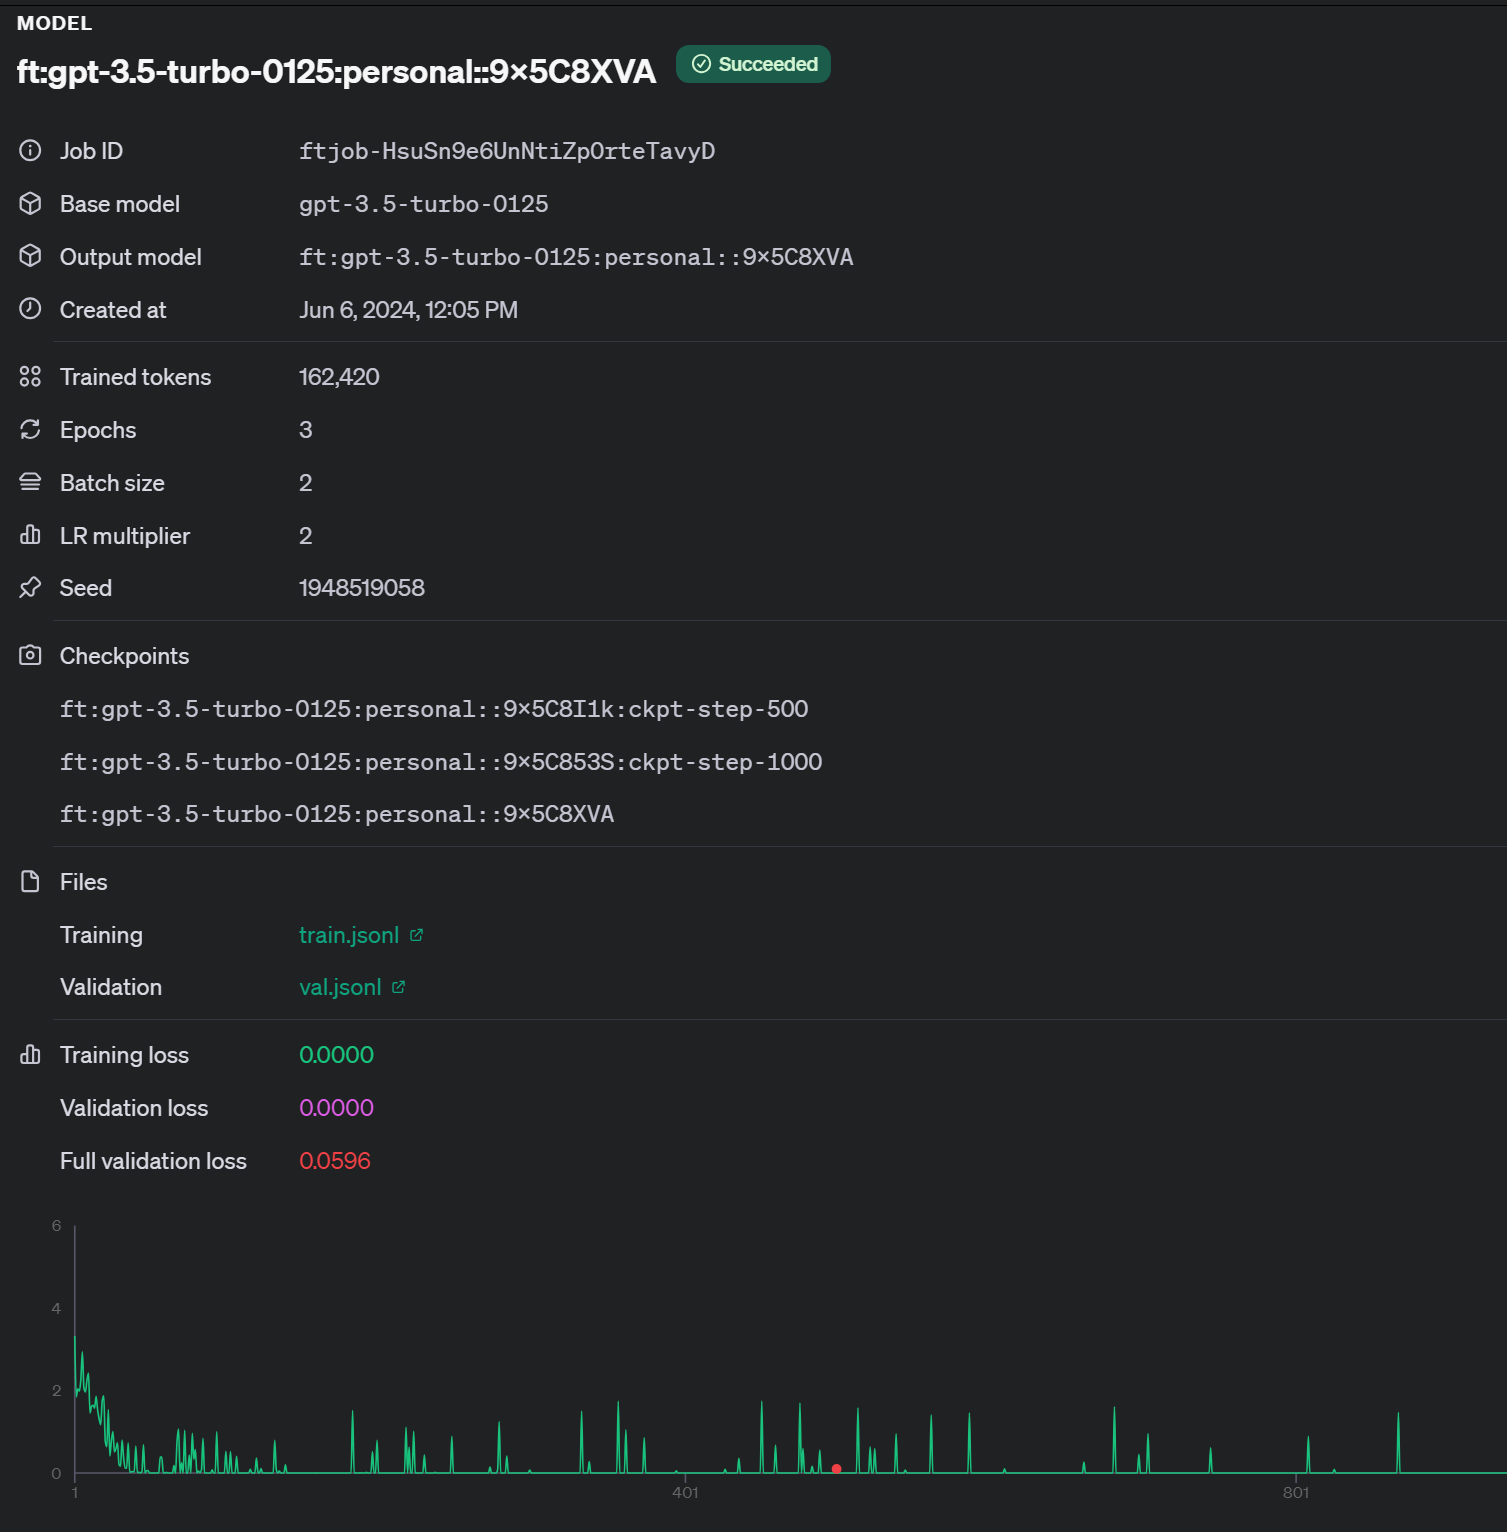

### Check our list of available models

Our fine-tuned model id (and checkpoint versions) should now appears in the list of available models.

Fine-tuned models start with the `ft:{base-model}` prefix.

In [149]:
available_models = [model.id for model in client.models.list()]
for model in sorted(available_models):
    if model.startswith('ft:'):
        print(model)


ft:gpt-3.5-turbo-0125:personal::9S3O96TD
ft:gpt-3.5-turbo-0125:personal::9S3O9Jww:ckpt-step-1000
ft:gpt-3.5-turbo-0125:personal::9S3O9Q9R:ckpt-step-500
ft:gpt-3.5-turbo-0125:personal::9TSgV6sR:ckpt-step-1000
ft:gpt-3.5-turbo-0125:personal::9TSgVvbd:ckpt-step-500
ft:gpt-3.5-turbo-0125:personal::9TSgWFtt
ft:gpt-3.5-turbo-0125:personal::9X5C853S:ckpt-step-1000
ft:gpt-3.5-turbo-0125:personal::9X5C8I1k:ckpt-step-500
ft:gpt-3.5-turbo-0125:personal::9X5C8XVA


In [183]:
gpt_model = 'ft:gpt-3.5-turbo-0125:personal::9X5C8XVA'

### Test our fine-tuned model

Our fine-tuned model now outputs a list of 3 intents as expected, after training it on the augmented dataset.  
As a reminder, it was only outputing 1 intent when trained on the original ATIS dataset.

In [184]:
message, intent = get_random_message_intent(val_df)
message_json = json.dumps({"text": message})

response = get_intent_predictions(message_json, intents_list, model=gpt_model)

data = json.loads(response)

print(f"Message: {message} | Intent: {intent}")
print(f"INPUT: {message_json}")
print(f"OUPTUT: {data}")

Message:  show flights from burbank to st. louis on monday | Intent: flight
INPUT: {"text": " show flights from burbank to st. louis on monday"}
OUPTUT: {'intent': 'flight'}


### Test model with additional intents
Again, let's make sure that our model is flexible and can adapt to new intents added to the prompt.

In [185]:
# add new intents to the list
expanded_intents_list = intents_list + ['air_sickness', 'medicine']

# create a new message using the new intents
messages = ['I am affraid to get sick in the plane', 'Do you have some painkillers for the flight?']

for message in messages:
    response = get_intent_predictions(message, expanded_intents_list, model=gpt_model)
    data = json.loads(response)
    openai_intent = data['intent']
    print(f"MESSAGE: {message}")
    print(f"OUTPUT: {data}")


MESSAGE: I am affraid to get sick in the plane
OUTPUT: {'intent': 'air_sickness'}
MESSAGE: Do you have some painkillers for the flight?
OUTPUT: {'intent': 'medicine'}


### Run another 100 predictions with it and compare it with the base model

To finish, I want to see if my fine-tuned model improved during the fine-tuning step. Let's run again 100 predictions on unseen messages from the test set and see if it predict the right intent.

GPT model: ft:gpt-3.5-turbo-0125:personal::9X5C8XVA


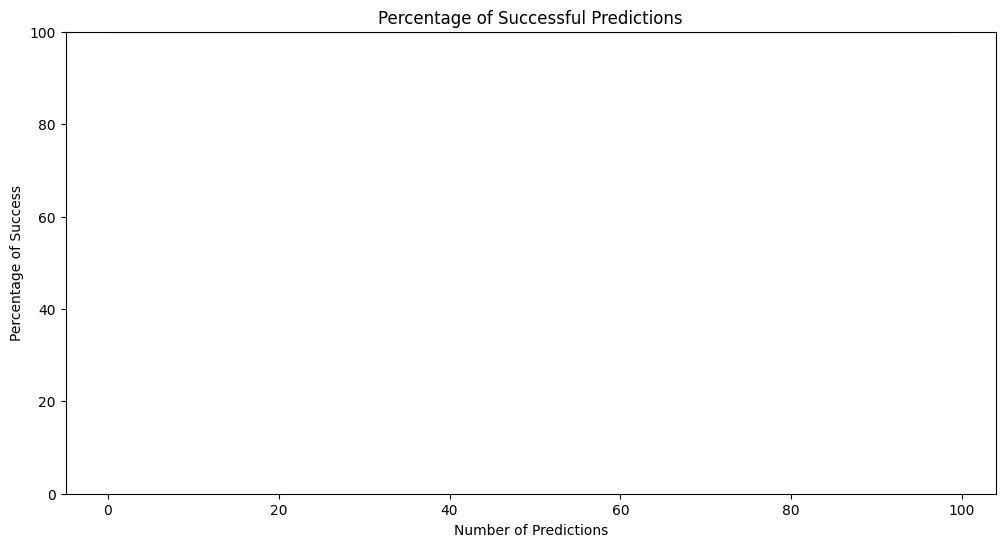

In [186]:
print('GPT model:', gpt_model)
asses_model_results(model=gpt_model, samples=100)

BEFORE FINE-TUNING:  

```
Predictions: 100
Successful Prediction: 82 (82%)
Failed Prediction: 18 (18%)
```

AFTER FINE-TUNING:  

```
Predictions: 100
Successful Prediction: 100 (100%)
Failed Prediction: 0 (0%)
```

We can see that fine-tuning our GPT model definitely improved its performance when predicting the intent of messages from our test dataset (unseen during the training step).

As a conclusion, we should think if fine-tuning the model is worth the invested time and money? I would say that for our use-case, fine-tuning probably is not that interesting, considering that the base version gets the intent right 80% or the time, or at least one with a very close meaning. Since we don't really know how the fine-tuning step is done and how layers of GPT transformers are tweaked, we should be careful and not necessarely fine-tune our model every time.

However, the possibility to specialise the model on a given task and the simplicity to switch between one model to another is definitely a precious asset that could come in handy, in the creation of Agents for instance: Based on the user input, we could trigger an agent specialized in customer support *('I need help changing my password')*, or another one in technical assistance *('My software keeps crashing at startup')*.